# 01 — Exploratory Data Analysis: UCI Online Retail II

**Dataset:** UCI Online Retail II (id=502)  
**Source:** UK-based online gift retailer, transactions 01/12/2009 – 09/12/2011  
**Intent:** Orient to the dataset and run EDA checks that justify later feature engineering for send-time optimization.

**References (optional reading):**
- UCI Machine Learning Repository — Online Retail II (id=502).
- Wickham, H. (2014). *Tidy Data*. Journal of Statistical Software.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

PROJECT_ROOT = Path.cwd().parent
RAW_DIR = PROJECT_ROOT / 'data' / 'raw'
CSV_PATH = RAW_DIR / 'online_retail_ii.csv'

print(f'Project root: {PROJECT_ROOT}')
print(f'CSV path: {CSV_PATH}')
print(f'File exists: {CSV_PATH.exists()}')

Project root: /Users/aayan/MarketingAnalytics/project
CSV path: /Users/aayan/MarketingAnalytics/project/data/raw/online_retail_ii.csv
File exists: True


## 1. Load Raw Data

**Intent:** Bring the raw CSV into a DataFrame and do a quick schema / time-span / preview check.

In [2]:
df = pd.read_csv(CSV_PATH, parse_dates=['InvoiceDate'])

# Add time columns upfront so they're available throughout the notebook
df['hour'] = df['InvoiceDate'].dt.hour
df['day_of_week'] = df['InvoiceDate'].dt.day_name()

print(f'Total rows: {len(df):,}')
print(f'Columns: {df.columns.tolist()}')
print(f'Date range: {df["InvoiceDate"].min()} \u2014 {df["InvoiceDate"].max()}')
print(f'\nRows by year:')
print(df['InvoiceDate'].dt.year.value_counts().sort_index())
df.head()

Total rows: 1,067,371
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'hour', 'day_of_week']
Date range: 2009-12-01 07:45:00 — 2011-12-09 12:50:00

Rows by year:
InvoiceDate
2009     45228
2010    522714
2011    499429
Name: count, dtype: int64


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,hour,day_of_week
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,7,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,7,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,7,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,7,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,7,Tuesday


## 2. Data Profile: Nulls and Duplicates

**Intent:** Quantify missingness and duplicate rows so we know what cleaning steps are required before modeling.

In [3]:
print('=== NULL COUNTS ===')
print(df.isnull().mean().mul(100).round(2).to_frame('null_pct'))

n_dups = df.duplicated().sum()
print(f'\n=== DUPLICATES ===')
print(f'Duplicate rows: {n_dups:,} ({n_dups/len(df)*100:.2f}%)')

=== NULL COUNTS ===
             null_pct
Invoice          0.00
StockCode        0.00
Description      0.41
Quantity         0.00
InvoiceDate      0.00
Price            0.00
Customer ID     22.77
Country          0.00
hour             0.00
day_of_week      0.00



=== DUPLICATES ===
Duplicate rows: 34,335 (3.22%)


## 3. Customer ID Analysis

**Intent:** Check how often `Customer ID` is missing, since customer-level features (recency/frequency/behavioral patterns) require an identifier.

In [4]:
# Single filtered DataFrame used throughout the notebook
df_with_cust = df.dropna(subset=['Customer ID'])

print(f'Unique CustomerIDs (before filtering): {df["Customer ID"].nunique():,}')
print(f'Rows with null CustomerID: {df["Customer ID"].isna().sum():,} ({df["Customer ID"].isna().mean()*100:.1f}%)')
print(f'\nRows after dropping null CustomerID: {len(df_with_cust):,}')
print(f'Unique CustomerIDs after filter: {df_with_cust["Customer ID"].nunique():,}')

Unique CustomerIDs (before filtering): 5,942
Rows with null CustomerID: 243,007 (22.8%)

Rows after dropping null CustomerID: 824,364
Unique CustomerIDs after filter: 5,942


## 4. Country Distribution

**Intent:** Understand the market mix (e.g., UK dominance) to anticipate segmentation and potential geographic bias.

In [5]:
uk_pct = (df['Country'] == 'United Kingdom').mean() * 100
print(f'UK row proportion: {uk_pct:.1f}%')

print('\n=== TOP 15 COUNTRIES BY TRANSACTION COUNT ===')
top_countries = df['Country'].value_counts().head(15)
print(top_countries)

UK row proportion: 91.9%

=== TOP 15 COUNTRIES BY TRANSACTION COUNT ===
Country
United Kingdom     981330
EIRE                17866
Germany             17624
France              14330
Netherlands          5140
Spain                3811
Switzerland          3189
Belgium              3123
Portugal             2620
Australia            1913
Channel Islands      1664
Italy                1534
Norway               1455
Sweden               1364
Cyprus               1176
Name: count, dtype: int64


=== TOP 15 COUNTRIES BY UNIQUE CUSTOMER COUNT ===
Country
United Kingdom     5410
Germany             107
France               95
Spain                41
Belgium              29
Portugal             24
Netherlands          23
Switzerland          22
Sweden               19
Italy                17
Finland              15
Australia            15
Channel Islands      14
Austria              13
Norway               13
Name: Customer ID, dtype: int64


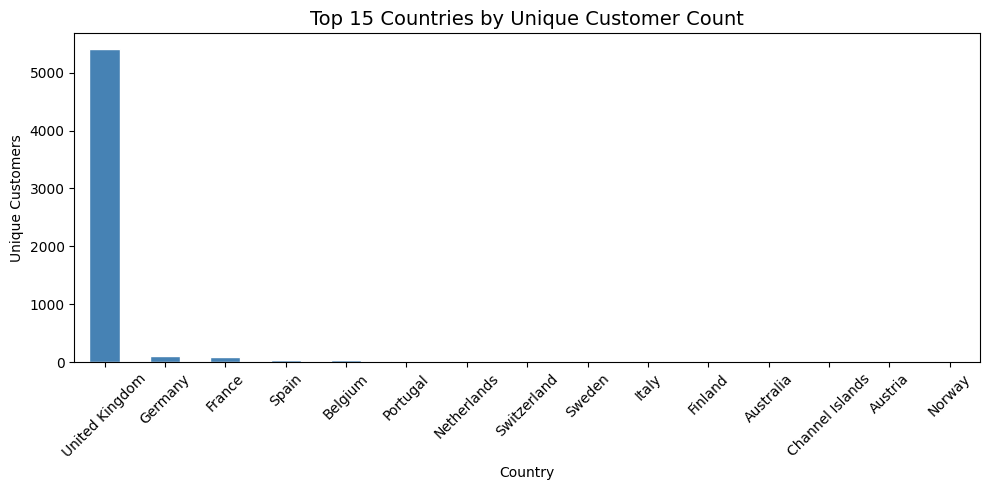

In [6]:
# Re-rank countries by unique customers and visualize
top_countries_cust = (
    df_with_cust.groupby('Country')['Customer ID']
    .nunique()
    .sort_values(ascending=False)
    .head(15)
)
print('=== TOP 15 COUNTRIES BY UNIQUE CUSTOMER COUNT ===')
print(top_countries_cust)

fig, ax = plt.subplots(figsize=(10, 5))
top_countries_cust.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
ax.set_title('Top 15 Countries by Unique Customer Count', fontsize=14)
ax.set_xlabel('Country')
ax.set_ylabel('Unique Customers')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 5. Cancellation Rate

**Intent:** Estimate how many rows represent cancellations/returns, which can distort purchase signals if not handled carefully.

In [7]:
cancellations = df['Invoice'].astype(str).str.startswith('C')
cancel_rate = cancellations.mean() * 100
print(f'Cancellation rows: {cancellations.sum():,}')
print(f'Cancellation rate: {cancel_rate:.2f}%')

print('\nCancellations by year:')
print(pd.DataFrame({'is_cancelled': cancellations, 'year': df['InvoiceDate'].dt.year})
      .groupby('year')['is_cancelled'].agg(['sum', 'mean'])
      .rename(columns={'sum': 'cancel_count', 'mean': 'cancel_rate'}))

Cancellation rows: 19,494
Cancellation rate: 1.83%

Cancellations by year:
      cancel_count  cancel_rate
year                           
2009          1015     0.022442
2010          9919     0.018976
2011          8560     0.017140


## 6. Hour and Day-of-Week Distributions

**Intent:** Explore when purchases happen across the week — these time patterns motivate the `send_hour` / `send_dow` features used later.

=== TRANSACTION COUNT BY HOUR ===
hour
6         41
7       1127
8      15985
9      68324
10     93248
11    121780
12    159846
13    150308
14    141513
15    135309
16     94055
17     57549
18     16991
19      9089
20      2205
21         1
dtype: int64


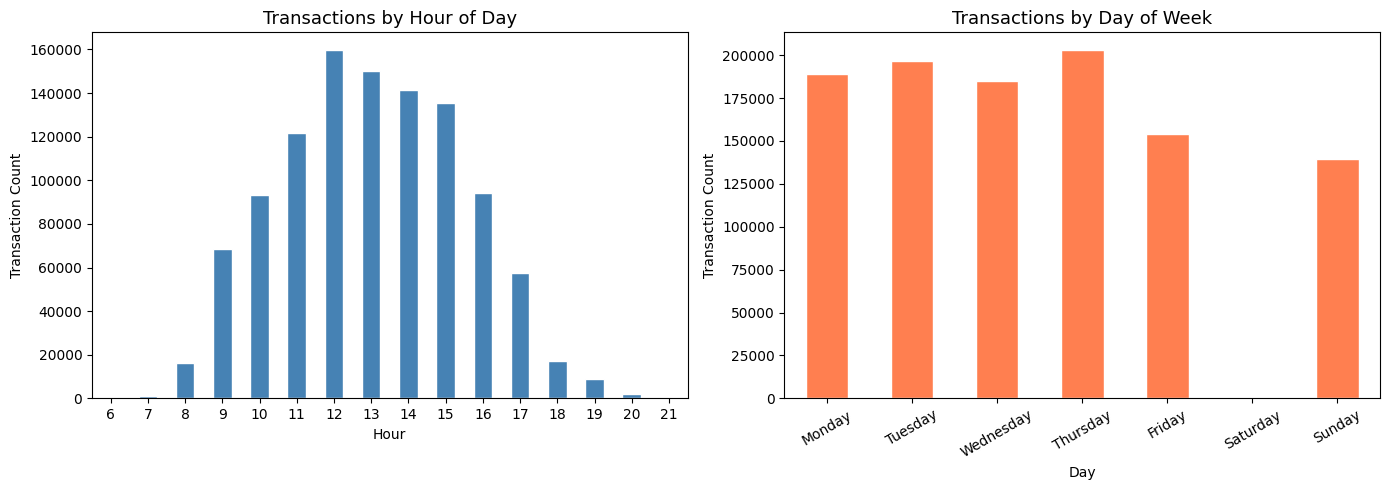

In [8]:
print('=== TRANSACTION COUNT BY HOUR ===')
hour_counts = df.groupby('hour').size()
print(hour_counts)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

hour_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Transactions by Hour of Day', fontsize=13)
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Transaction Count')
axes[0].tick_params(axis='x', rotation=0)

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = df.groupby('day_of_week').size().reindex(dow_order)
dow_counts.plot(kind='bar', ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('Transactions by Day of Week', fontsize=13)
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Transaction Count')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

## 7. Modal Purchase Hour Distribution Across Customers

**Intent:** Create a customer-specific "typical purchase hour" feature and see how concentrated (or diverse) customer habits are.

Customers with modal hour computed: 5,942

Modal hour distribution across customers:
modal_hour
7        6
8      135
9      391
10     650
11     689
12    1050
13     963
14     796
15     658
16     367
17     165
18      38
19      27
20       7
Name: count, dtype: int64


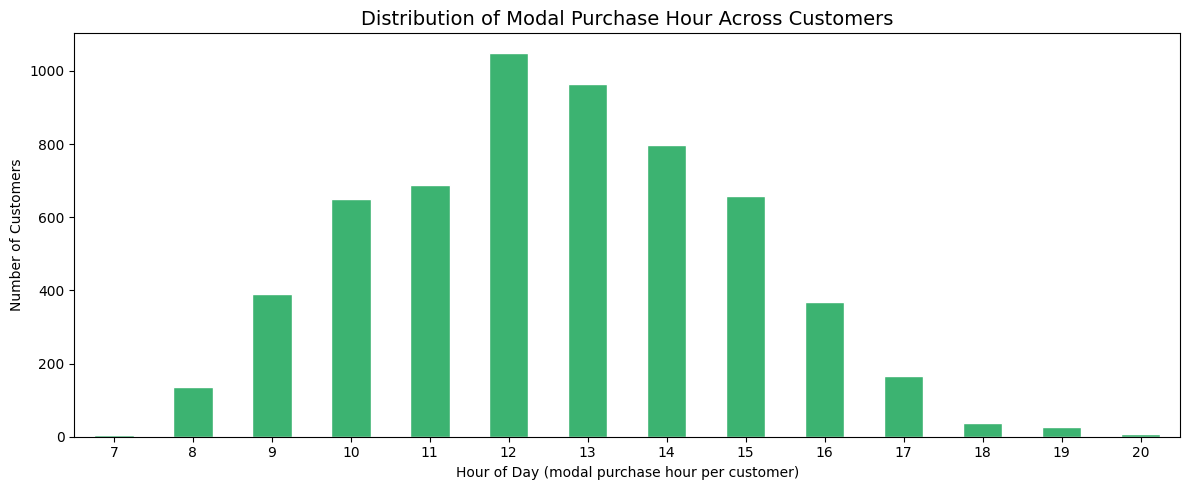


Most common modal purchase hour: 12:00


In [9]:
customer_modal_hour = (
    df_with_cust.groupby('Customer ID')['hour']
    .agg(lambda x: x.mode().iloc[0])
    .reset_index()
    .rename(columns={'hour': 'modal_hour'})
)

print(f'Customers with modal hour computed: {len(customer_modal_hour):,}')
print('\nModal hour distribution across customers:')
modal_dist = customer_modal_hour['modal_hour'].value_counts().sort_index()
print(modal_dist)

fig, ax = plt.subplots(figsize=(12, 5))
modal_dist.plot(kind='bar', ax=ax, color='mediumseagreen', edgecolor='white')
ax.set_title('Distribution of Modal Purchase Hour Across Customers', fontsize=14)
ax.set_xlabel('Hour of Day (modal purchase hour per customer)')
ax.set_ylabel('Number of Customers')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

most_common_modal_hour = customer_modal_hour['modal_hour'].mode().iloc[0]
print(f'\nMost common modal purchase hour: {most_common_modal_hour}:00')

## 8. Summary Statistics

**Intent:** Consolidate the key EDA checkpoints into a short, reusable summary.

In [10]:
print('=== EDA SUMMARY ===')
print(f'Total rows:                 {len(df):>12,}')
print(f'Unique CustomerIDs (raw):   {df["Customer ID"].nunique():>12,}')
print(f'Null CustomerID rows:       {df["Customer ID"].isna().sum():>12,}')
print(f'Duplicate rows:             {df.duplicated().sum():>12,}')
print(f'Cancellation rate:          {cancel_rate:>11.2f}%')
print(f'UK transaction proportion:  {uk_pct:>11.1f}%')
print(f'Date range start:           {df["InvoiceDate"].min()}')
print(f'Date range end:             {df["InvoiceDate"].max()}')
print(f'Peak transaction hour:      {hour_counts.idxmax()}:00')
print(f'Most common modal hour:     {most_common_modal_hour}:00')
print(f'Number of countries:        {df["Country"].nunique():>12,}')

=== EDA SUMMARY ===
Total rows:                    1,067,371
Unique CustomerIDs (raw):          5,942
Null CustomerID rows:            243,007
Duplicate rows:                   34,335
Cancellation rate:                 1.83%
UK transaction proportion:         91.9%
Date range start:           2009-12-01 07:45:00
Date range end:             2011-12-09 12:50:00
Peak transaction hour:      12:00
Most common modal hour:     12:00


Number of countries:                  43
